In this lab we will experiment with some trained GAN models. First we will download one trained on face data


In [21]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [22]:

print(model.netG)

DataParallel(
  (module): GNet(
    (scaleLayers): ModuleList(
      (0): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (3): ModuleList(
        (0): EqualizedConv2d(
          (module): Con

We will visualize some randomly generated faces. Run this cell a few times to generate new faces

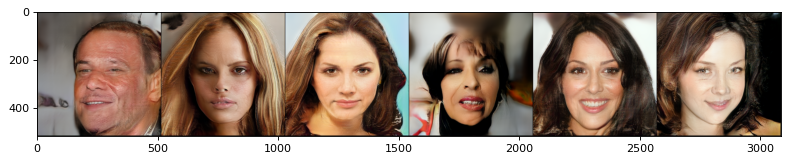

In [31]:
num_images = 6
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.netG(noise).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


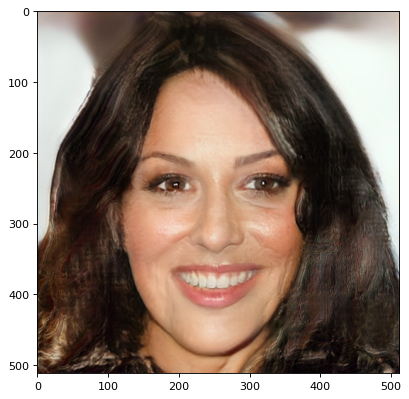

In [33]:
img1=generated_images[4]
noise1=noise[4]

grid = torchvision.utils.make_grid(img1.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


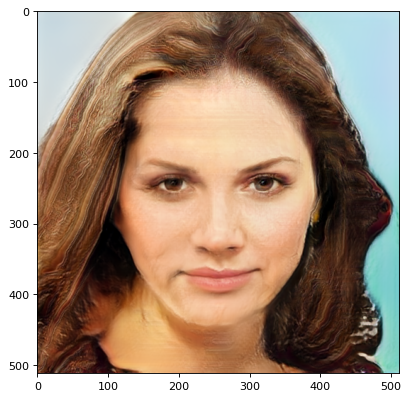

In [34]:
img2=generated_images[2]
noise2=noise[2]

grid = torchvision.utils.make_grid(img2.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [35]:
print(type(noise))
print(generated_images.shape)

<class 'torch.Tensor'>
torch.Size([6, 3, 512, 512])


(1) Find two random faces images that you prefer (e.g. the more realistic) and their noise. For example you may by rerunning the cell above a few times to find better faces. Write a function that will interpolate between two randomly generated faces. It will take a noise vector of size 2x512. Let's denote noise_1 and noise_2 the first and 2nd row. As above create 8 intermediate values that interpolate between them. 

e.g. if we had just one intermediate value we would end up with  noise_1, (noise_1+noise_2)/2, noise_2

pass these through the generator (e.g. by putting them in a 8x512 noise tensor) and visualize the interpolation

In [36]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
def interpolate_points(p1, p2, n_steps=6):
  diff=p2-p1
  vectors = [p1]
  for i in range(1,n_steps+1):
    vectors.append(p1+ diff*(i/n_steps))
  vectors.append(p2)
  return asarray(vectors)
 


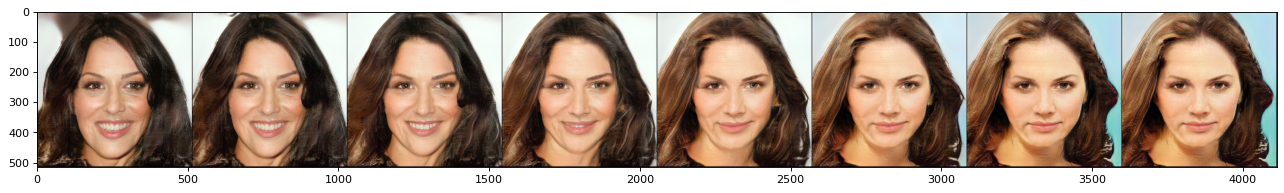

In [37]:
res=interpolate_points(noise1,noise2)
tensors=torch.zeros([8, 512], dtype=torch.float)
for id in range(len(res)):
  tensors[id]=res[id]
# res=torch.from_numpy(res[0])
len(res[0])
with torch.no_grad():
    generated_images = model.netG(tensors).detach()

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(20, 10), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

We will now experiment with the bigGAN model trained on natural images. You can find the implementation and further documentation here https://github.com/huggingface/pytorch-pretrained-BigGAN. Run the cells below to download the model and generate some random images.

In [10]:
!pip install pytorch-pretrained-biggan
!pip install libsixel-python
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 133kB 12.5MB/s 
     |████████████████████████████████| 7.4MB 17.9MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
ERROR: botocore 1.20.49 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Created wheel for libsixel-python: filename=libsixel_python-0.5.0-cp37-none-any.whl size=12275 sha256=45b860303d398da51be57e5794dd941b756cb02f9c4c4b7ff27b24f314754d22
  Stored in directory: /root/.cache/pip/wheels/83/ba/62/a3c568b79bf35a7a79d44cf0ceb11212006484019a4413d5d1
Successfully built libsixel-python
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import matplotlib.pyplot as plt
import torchvision


# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=6)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

100%|██████████| 715/715 [00:00<00:00, 310834.10B/s]


We visualize the generated images

torch.Size([6, 128])
torch.Size([6, 1000])


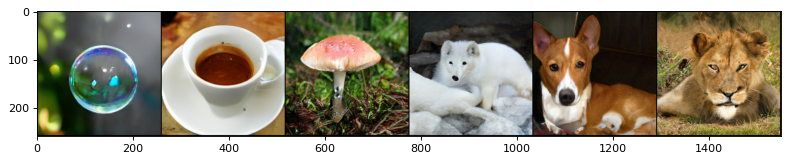

In [12]:
output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

torch.Size([6, 128])
torch.Size([6, 1000])


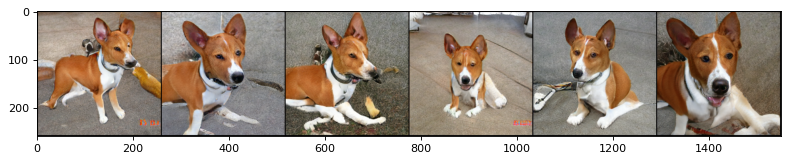

In [52]:

# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['dog','dog','dog','dog','dog','dog'], batch_size=6)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

(2) Let's experiment with interpolating between different images in this model as we did in the face images. Note the BigGAN takes both a class vector and a random noise. 
(a) Sample two random images from the same category such as "dog" and interpolate between them with 8 intermediate steps and using the same class vector
(b) Sample two random images from two diff classes (e.g. "dog" and "mushroom") and interpolate between them. For the class conditionin variable you may interpolate between these as well for best results.

Feel free to try other combinations and categories.

2.A

(8,)
torch.Size([8, 128])
torch.Size([8, 1000])


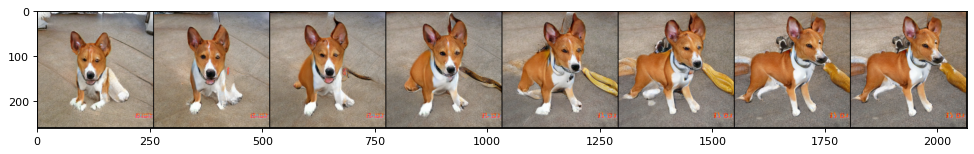

In [53]:
steps=8
res=interpolate_points(noise_vector[3],noise_vector[0],steps-2)
print(res.shape)
tensors=torch.zeros([steps, 128], dtype=torch.float)
for id in range(len(res)):
  tensors[id]=res[id]
# res=torch.from_numpy(res[0])
len(res[0])
classes=[]
for i in range(steps):
  classes.append('dog')
class_vector = one_hot_from_names(classes, batch_size=steps)

# All in tensors
noise_vector = tensors
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(15, 10), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [72]:
import numpy as np
steps=32
dog_class_vector = one_hot_from_names(['mushroom'], batch_size=1)[0]
lion_class_vector = one_hot_from_names(['lion'], batch_size=1)[0]
class_inter_res=interpolate_points(dog_class_vector,lion_class_vector ,steps-2)
print(class_inter_res)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [73]:
for c in class_inter_res:
  print(np.nonzero(c))

(array([947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291, 947]),)
(array([291]),)
(array([291]),)


(32, 128)
torch.Size([32, 128])
torch.Size([32, 1000])


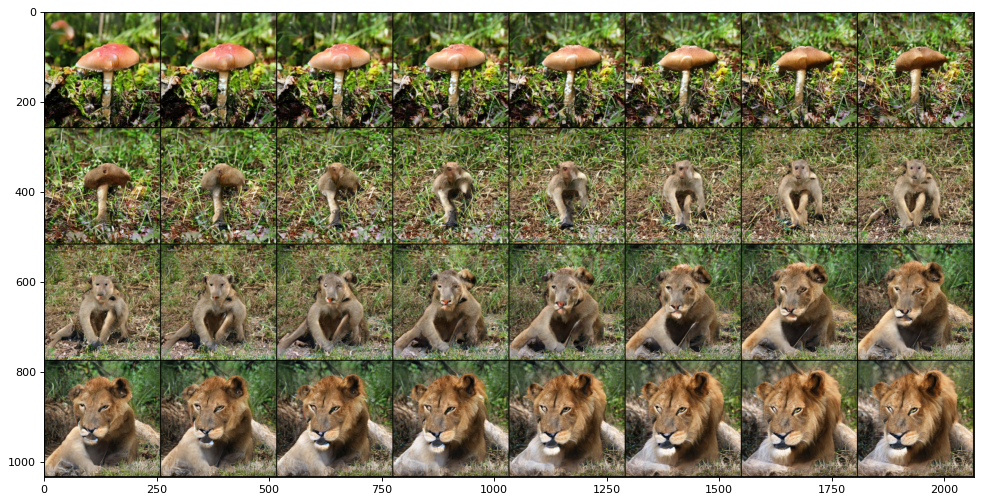

In [74]:

truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','cat','lion'], batch_size=6)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

res=interpolate_points(noise_vector[2],noise_vector[5],steps-2)
print(res.shape)
tensors=torch.zeros([steps, 128], dtype=torch.float)
for id in range(len(res)):
  tensors[id]=torch.from_numpy(res[id])
# res=torch.from_numpy(res[0])
len(res[0])
# classes=[]
# for i in range(steps):
#   classes.append('lion')

# class_vector = one_hot_from_names(classes, batch_size=steps)

# class_vector = one_hot_from_names(['mushroom','squirrel_monkey','cat','cat','tiger','tiger','lion','lion'], batch_size=6)

# All in tensors
noise_vector = tensors
class_vector = torch.from_numpy(class_inter_res)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, 0.4)

# If you have a GPU put back on CPU
output = output.to('cpu')

output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(15, 10), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())